In [1]:
import sys
import sklearn.utils
import pandas as pd
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

In [2]:
sys.path.insert(0, "..")

In [3]:
from hmm import plots, CategoricalVariationalHMM, CategoricalVariationalMHMM, CategoricalHMM, scoring, HMMSearch
from hmm.datasets.synthetic import get_categorical_beal

In [4]:

random_state = sklearn.utils.check_random_state(43)
data = get_categorical_beal(random_state)[0]

In [5]:
data.shape

(18, 60)

In [6]:

best = None
model = CategoricalVariationalHMM.CategoricalVariationalHMM(
        n_components=12, n_iterations=400, n_inits=5, pi_prior=1
    )
model.fit(data)

CategoricalVariationalHMM(A_prior=None, B_prior=None,
             implementation='scaling', n_components=12, n_features=None,
             n_inits=5, n_iterations=400, n_jobs=-1, pi_prior=1,
             random_state=None, tol=1e-06, verbose=0)

In [7]:
model.num_free_params()

7

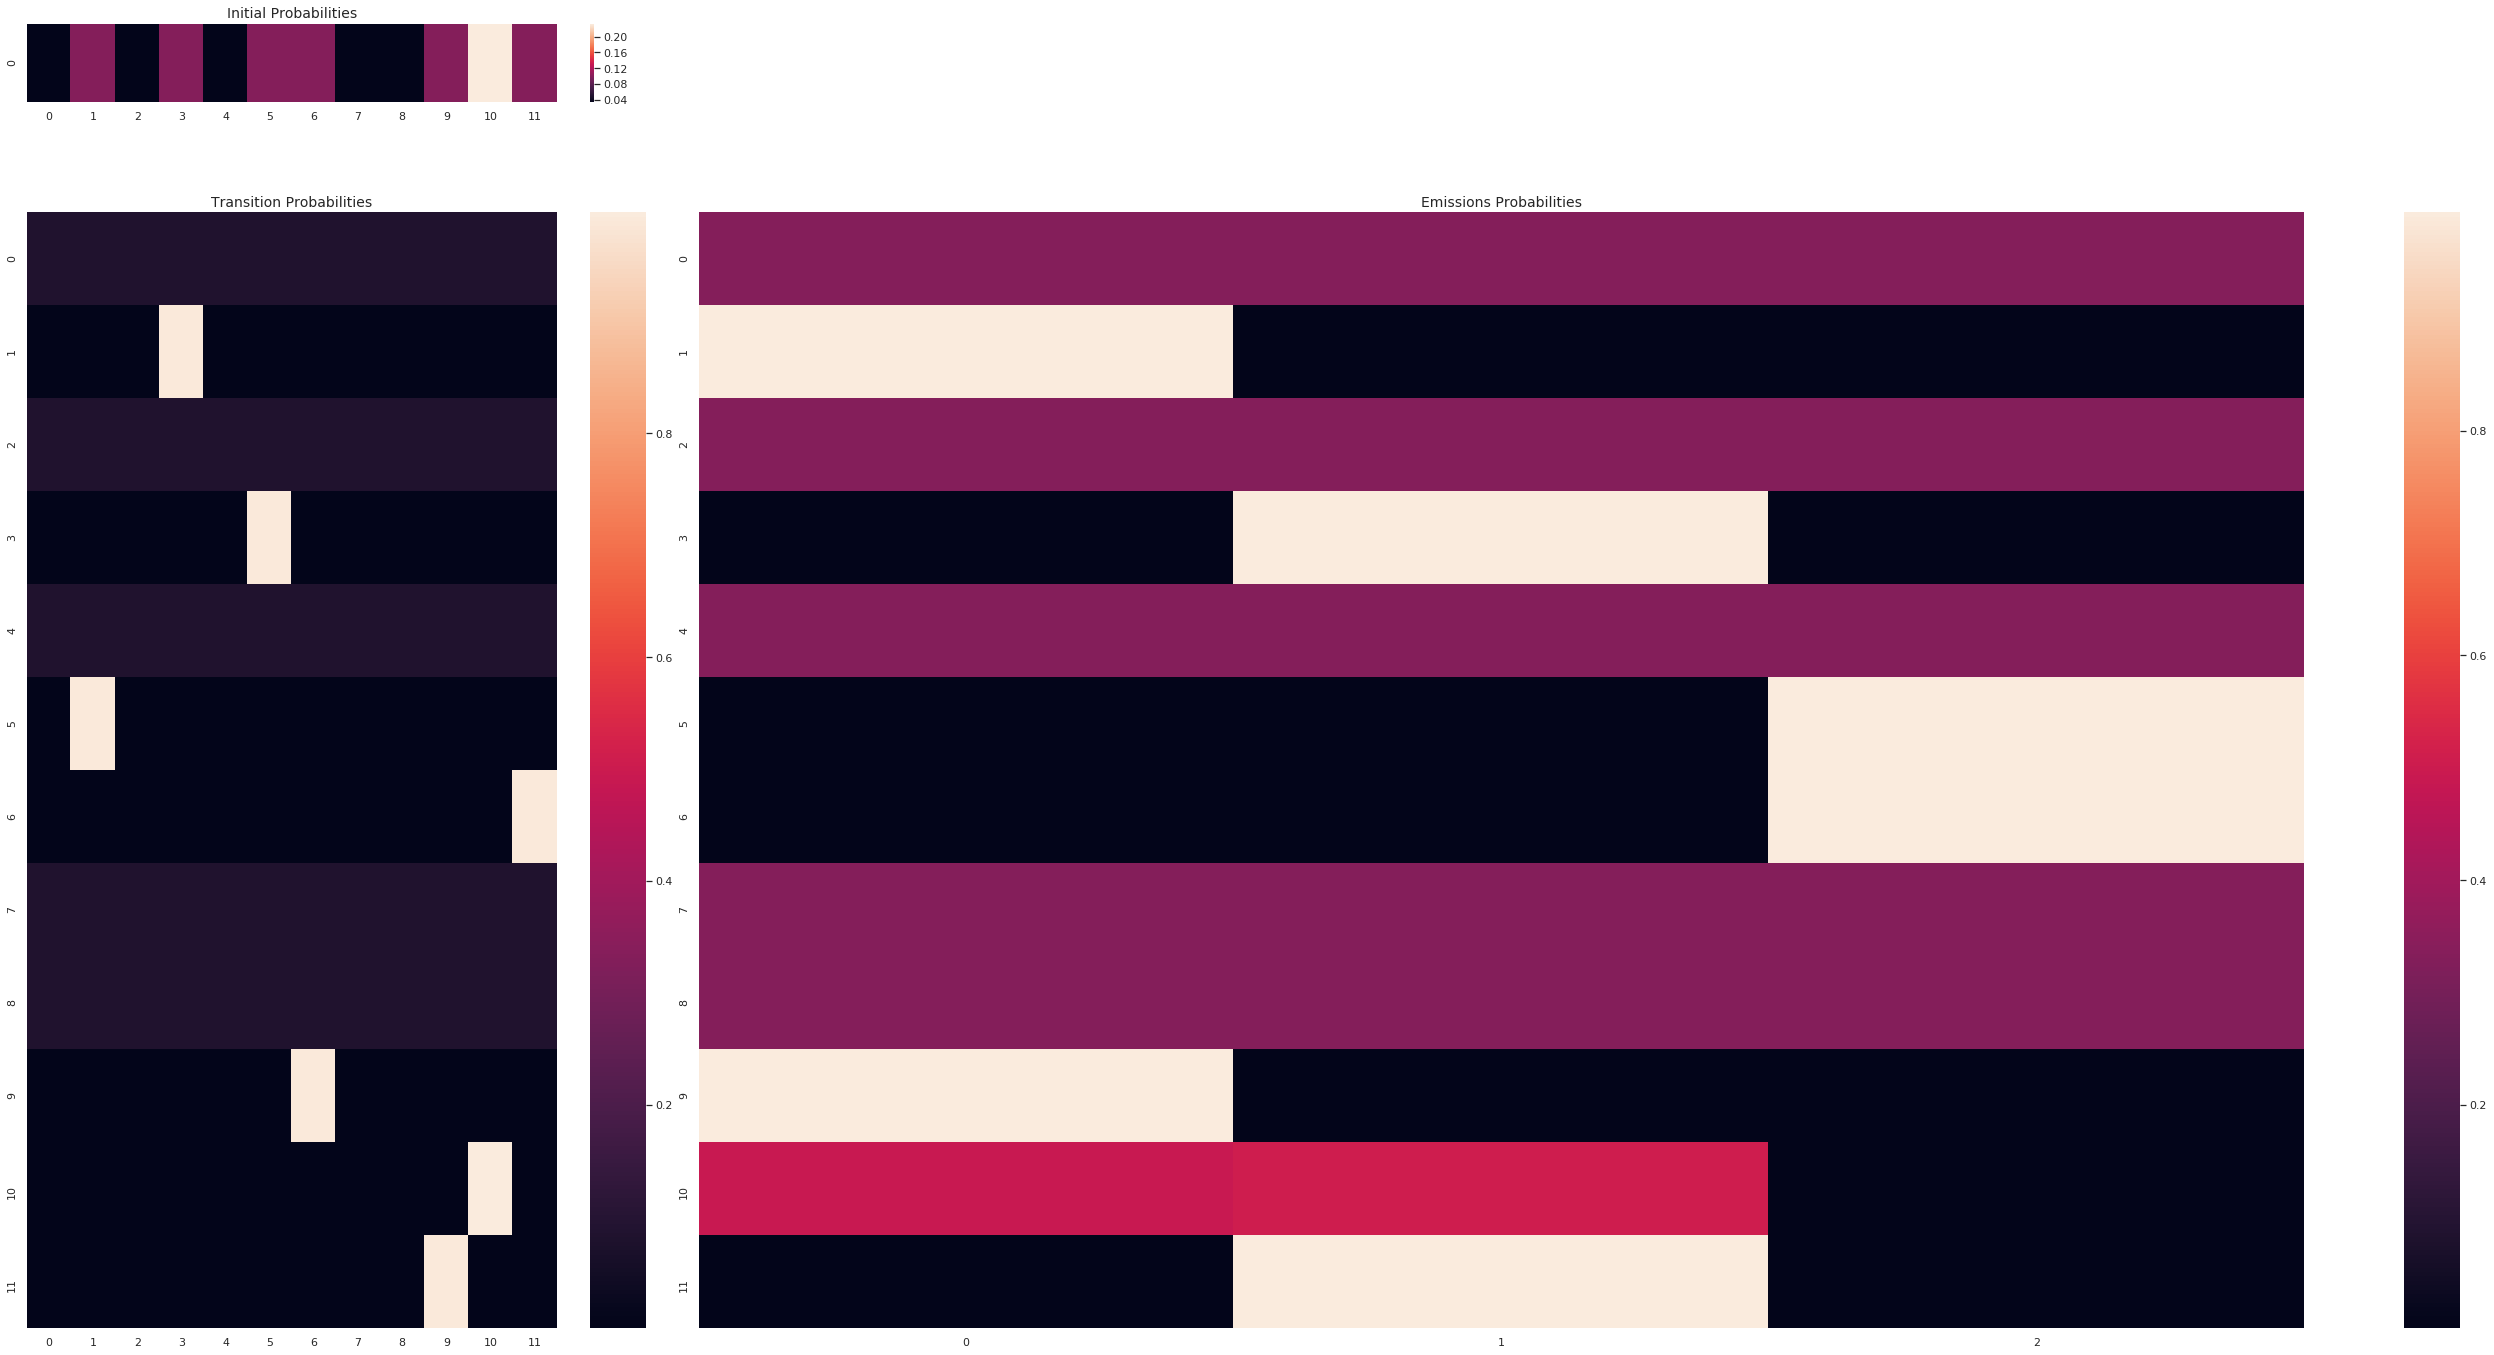

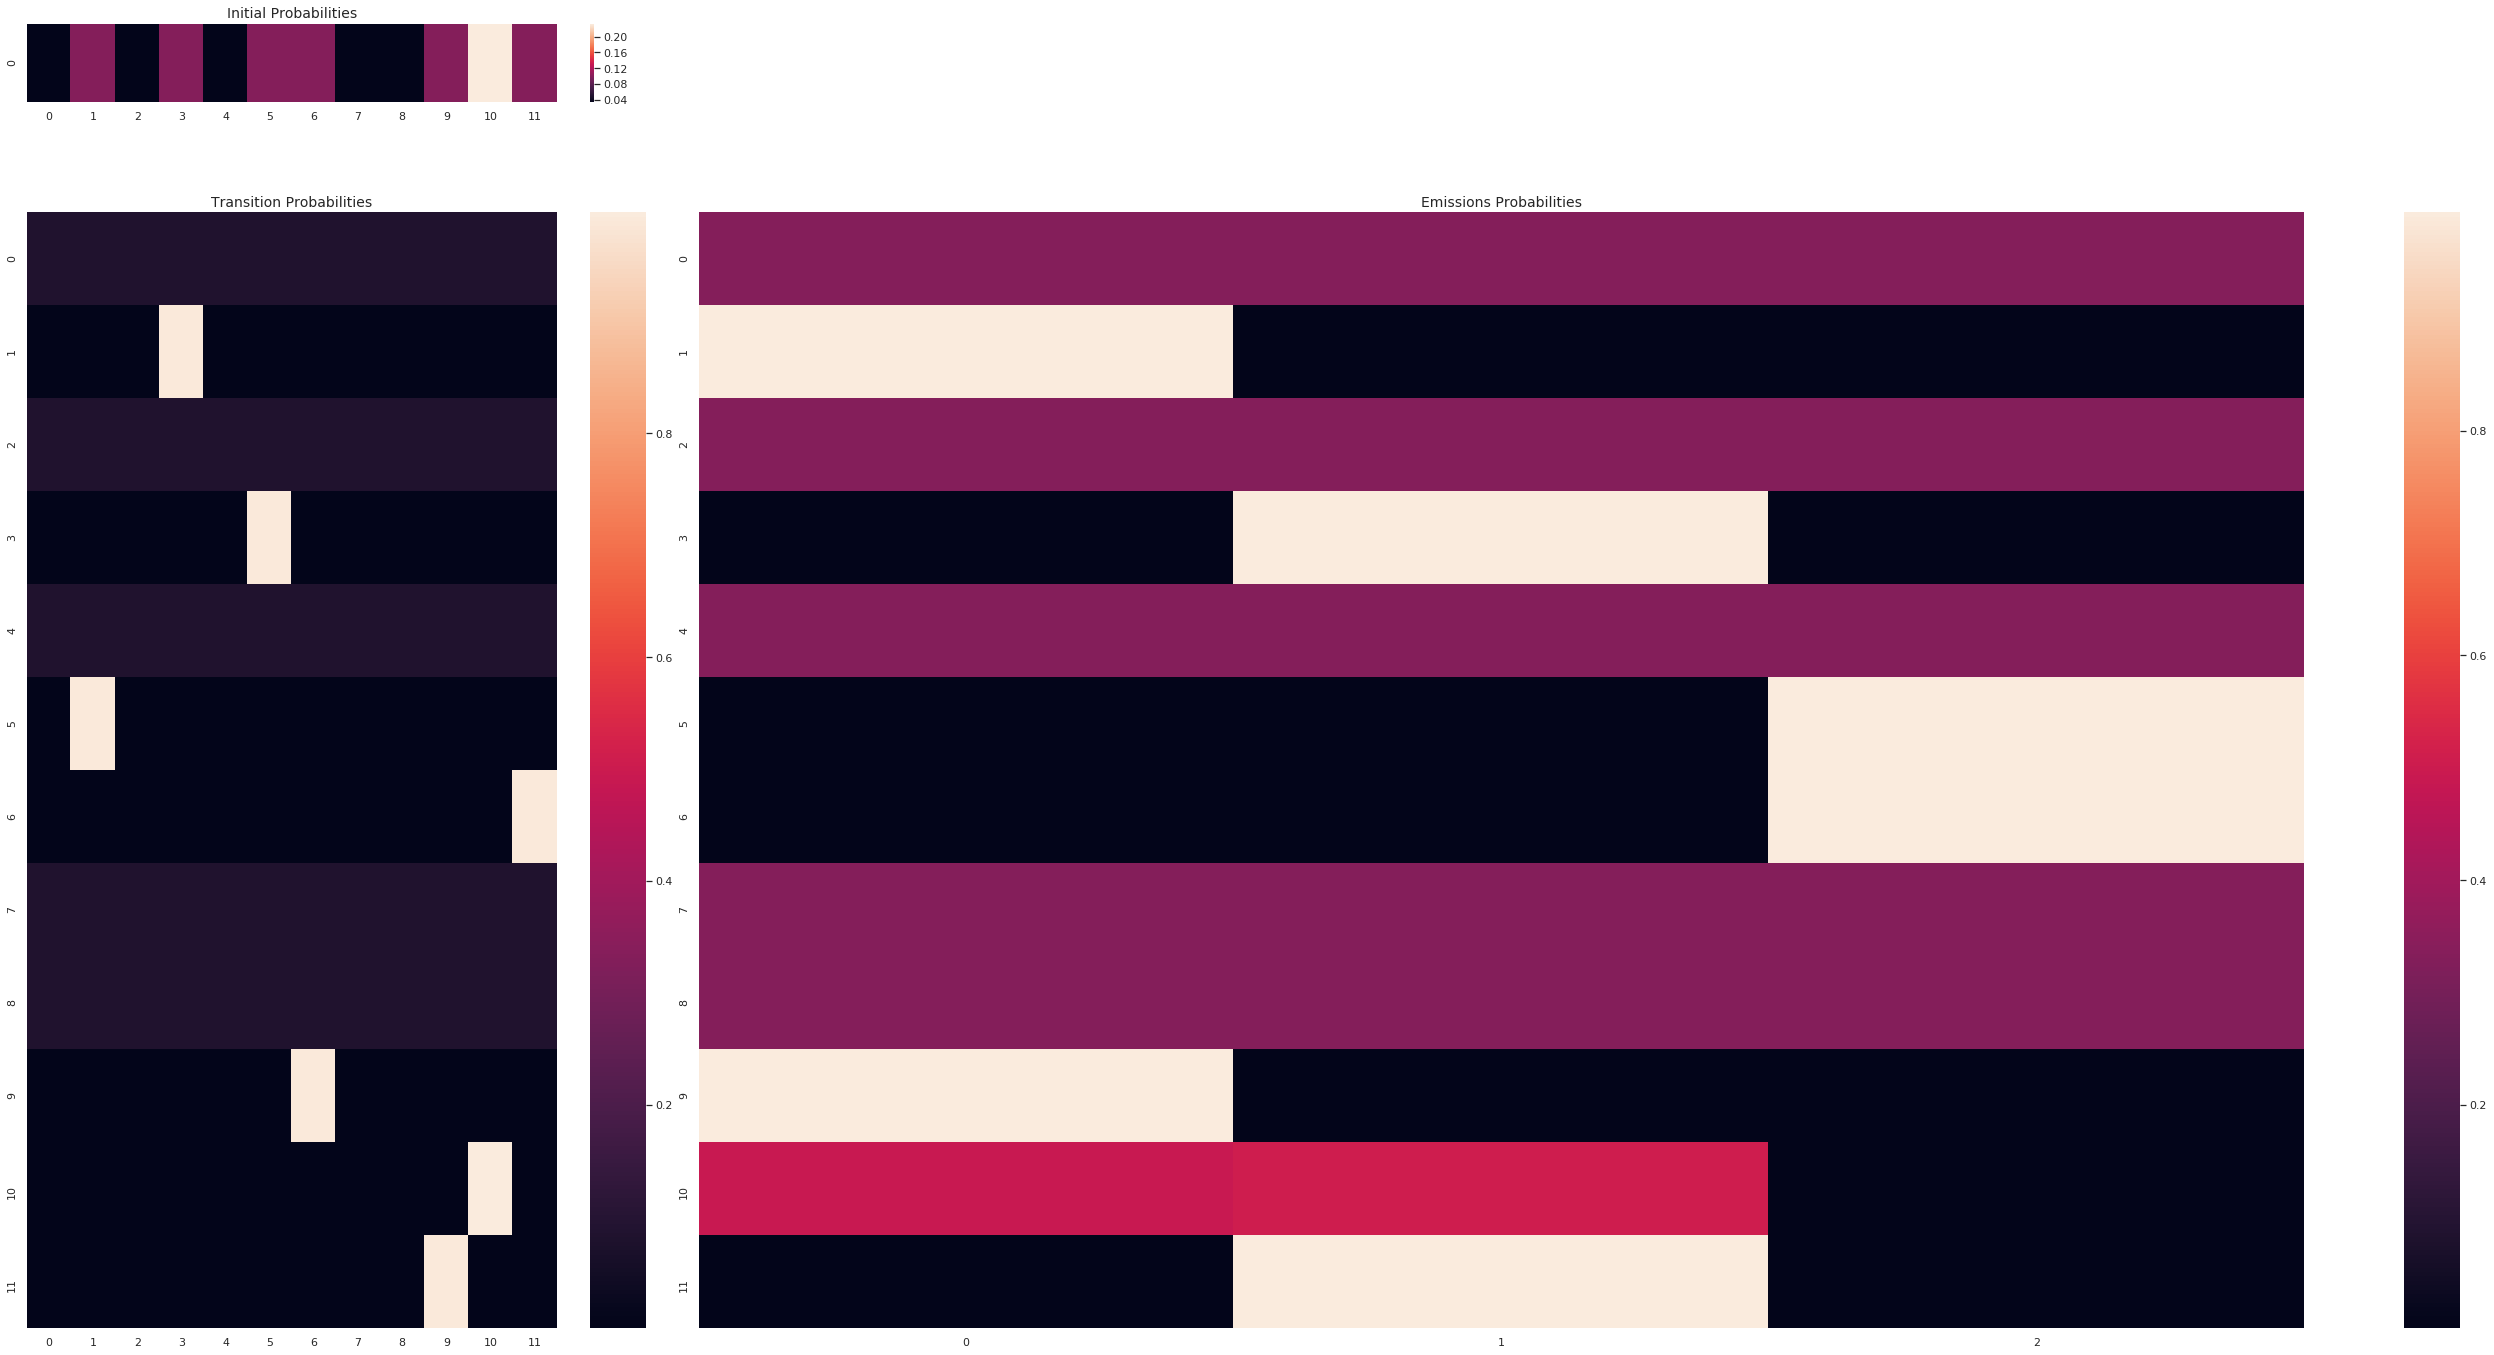

In [8]:
plots.hinton_diagram(
    model.pi_,
    model.A_,
    model.B_)

In [9]:
model.lower_bound_

[-1216.665647232544,
 -771.5219929395903,
 -618.0680534059152,
 -507.0844298455843,
 -443.7613059835275,
 -400.29516044471427,
 -388.59853305330535,
 -384.9653850914184,
 -383.26103763542335,
 -382.94039412121697,
 -382.9137613904225,
 -382.90416356969985,
 -382.8939020031846,
 -382.88291117820285,
 -382.8711294801732,
 -382.85849272317944,
 -382.8449322556676,
 -382.8303737716758,
 -382.81473637014454,
 -382.79793166083914,
 -382.7798628207804,
 -382.76042354717686,
 -382.7394968679299,
 -382.716953773727,
 -382.69265163265806,
 -382.6664323415174,
 -382.63812015790677,
 -382.6075191438071,
 -382.57441013363666,
 -382.53854711656174,
 -382.49965289217903,
 -382.45741381785166,
 -382.4114734110957,
 -382.36142449591176,
 -382.3067994794173,
 -382.2470582025313,
 -382.1815726071408,
 -382.1096071738607,
 -382.03029366474397,
 -381.942598083471,
 -381.845276826068,
 -381.7368175455258,
 -381.61535796299677,
 -381.4785721427727,
 -381.32350754207226,
 -381.14634543338303,
 -380.9420381002

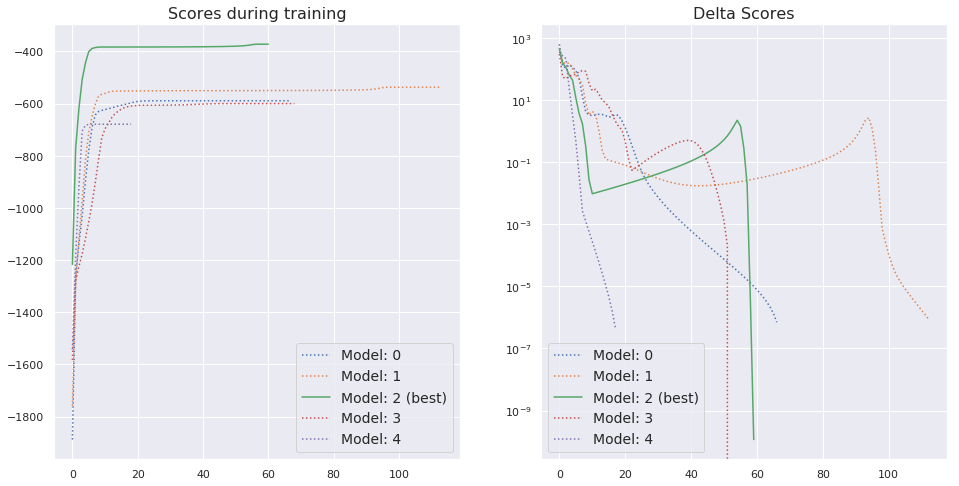

In [10]:
_ = plots.multiple_learning_plot(model.explored_lower_bounds_)

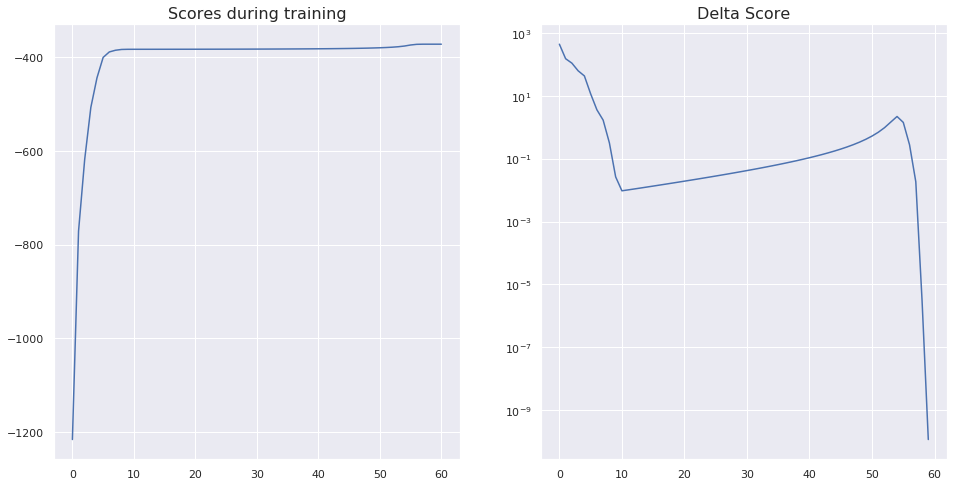

In [11]:
_ = plots.learning_plot(model.lower_bound_)

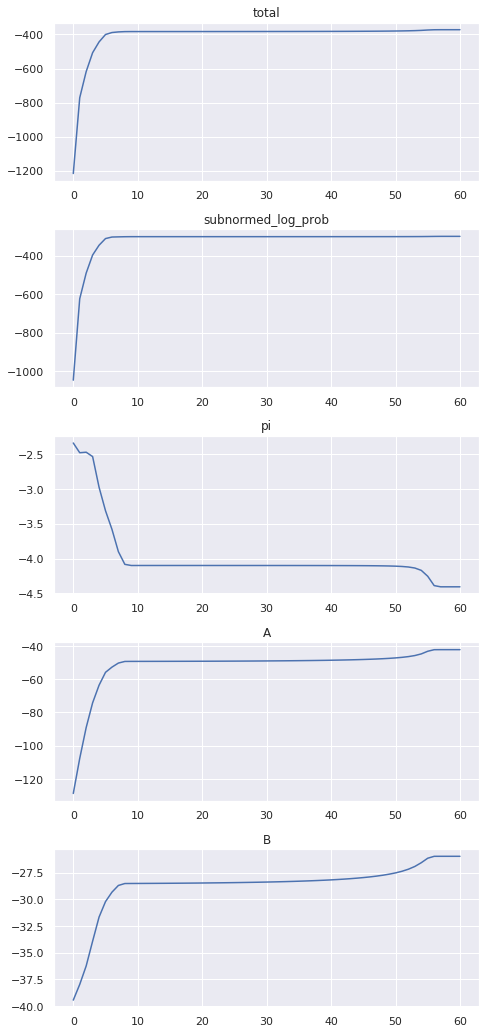

In [12]:
_ = plots.plot_verbose_energies(model.verbose_lower_bound_)

In [13]:
mixture = CategoricalVariationalMHMM.CategoricalVariationalMHMM(
    n_mixture_components=3, 
    n_components=3, 
    n_inits=40, 
    n_iterations=500
)

In [14]:
mixture.fit(data)

CategoricalVariationalMHMM(A_prior='uniform', B_prior='uniform',
              allowed_to_use_log=True, implementation='scaling',
              mixture_weights_prior=None, n_components=3, n_features=None,
              n_inits=40, n_iterations=500, n_jobs=-1,
              n_mixture_components=3, pi_prior='uniform',
              random_state=None, tol=1e-06, verbose=0)

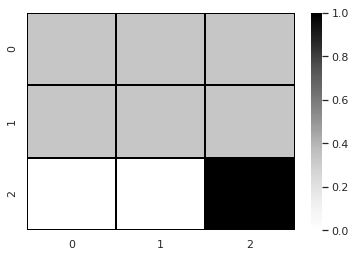

In [15]:
sns.heatmap(mixture.A_normalized_[2], vmin=0, vmax=1, cmap="Greys", linewidths=1, linecolor="black")

In [16]:
import matplotlib.gridspec as fs
import seaborn as sns

def categorical_mixture_hinton(mixture_weights, pi, A, B, vmin=None, vmax=None, b_vals=None, fontsize=14, hm_args={}):

    f, grid = generic_mixture_hinton_diagram(mixture_weights, pi, A, vmin, vmax, fontsize, hm_args, colorbar=False)

    num_components = A.shape[0]
    num_states = A.shape[1]
    start = 0 
    if b_vals is None:
        b_vals = np.arange(B.shape[-1])
    colorbar=True
    for component in range(num_components):
        start += 2
        ax = f.add_subplot(grid[start:start + num_states, num_states:])
        #if component > 0 and vmin is not None and vmax  is not None:
        #    colorbar = False
        sns.heatmap(B[component], ax=ax, vmin=vmin, vmax=vmax, xticklabels=b_vals, cbar=colorbar, **hm_args)
        ax.set_title("Emissions Probabilities", size=fontsize)
        start += num_states
    f.tight_layout()
    return f

def generic_mixture_hinton_diagram(mixture_weights, pi, A, vmin, vmax, fontsize, hm_args, colorbar=True):
    num_components = A.shape[0]
    num_states = A.shape[1]

    f = plt.figure(figsize=(3*(num_states), num_states * num_components))
    grid = gs.GridSpec(num_components * (2 + num_states), num_states*4)

    start = 0
    if vmin is None or vmax is None:
        colorbar = True
    for component in range(num_components):
        ax = f.add_subplot(grid[start+1:start+2, num_states:])
        ax.set_title("Component: {}, size: {:.3f}".format(component, mixture_weights[component]), size=fontsize +2)
        ax.grid(False)
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax = f.add_subplot(grid[start:start+2, :num_states])
        sns.heatmap(pi[component, None, :], ax=ax, vmin=vmin, vmax=vmax, cbar=colorbar, **hm_args)
        ax.set_title("Initial Probabilities", size=fontsize)
        start += 2
        ax = f.add_subplot(grid[start:start+num_states, :num_states])
        sns.heatmap(A[component], ax=ax, vmin=vmin, vmax=vmax, cbar=colorbar, **hm_args)
        ax.set_title("Transition Probabilities", size=fontsize)
        start += num_states
    return f, grid

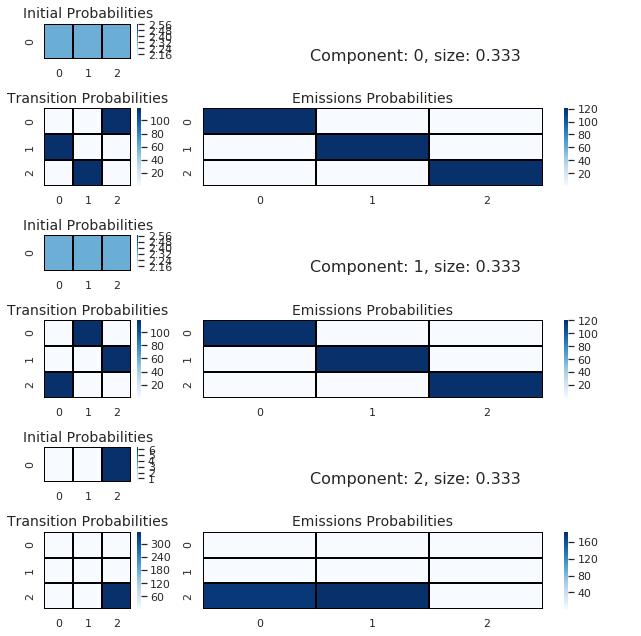

In [17]:
fig = categorical_mixture_hinton(
    mixture.mixture_weights_normalized_, 
    mixture.pi_posterior_, 
    mixture.A_posterior_,
    mixture.B_posterior_, 

    #hm_args={"cmap":"Greys", "linewidths":1, "linecolor":"black"}
    #hm_args={"center":0.5}
    
    #hm_args={"cmap":"Blues"}
    hm_args={"cmap":"Blues", "linewidths":1, "linecolor":"black"}
)
#fig.savefig("../../thesis/report/graphics/hinton_mixture_categorical_3_3.png")

In [18]:
mixture.verbose_lower_bound_[-1]

{'iteration': 27,
 'total': -374.4062376319522,
 'component_states': -20.755539611548695,
 'component_weights': -2.497943743898624,
 'pi': -4.515836040673195,
 'A': -25.237492421084994,
 'B': -25.967244956732817,
 'subnormed_log_prob': -295.43218085801385}

In [19]:
model.verbose_lower_bound_[-1]

{'iteration': 60,
 'total': -372.01113857955596,
 'pi': -4.40681999936762,
 'A': -42.3024735211077,
 'B': -25.96725188992761,
 'subnormed_log_prob': -299.33459316915304}

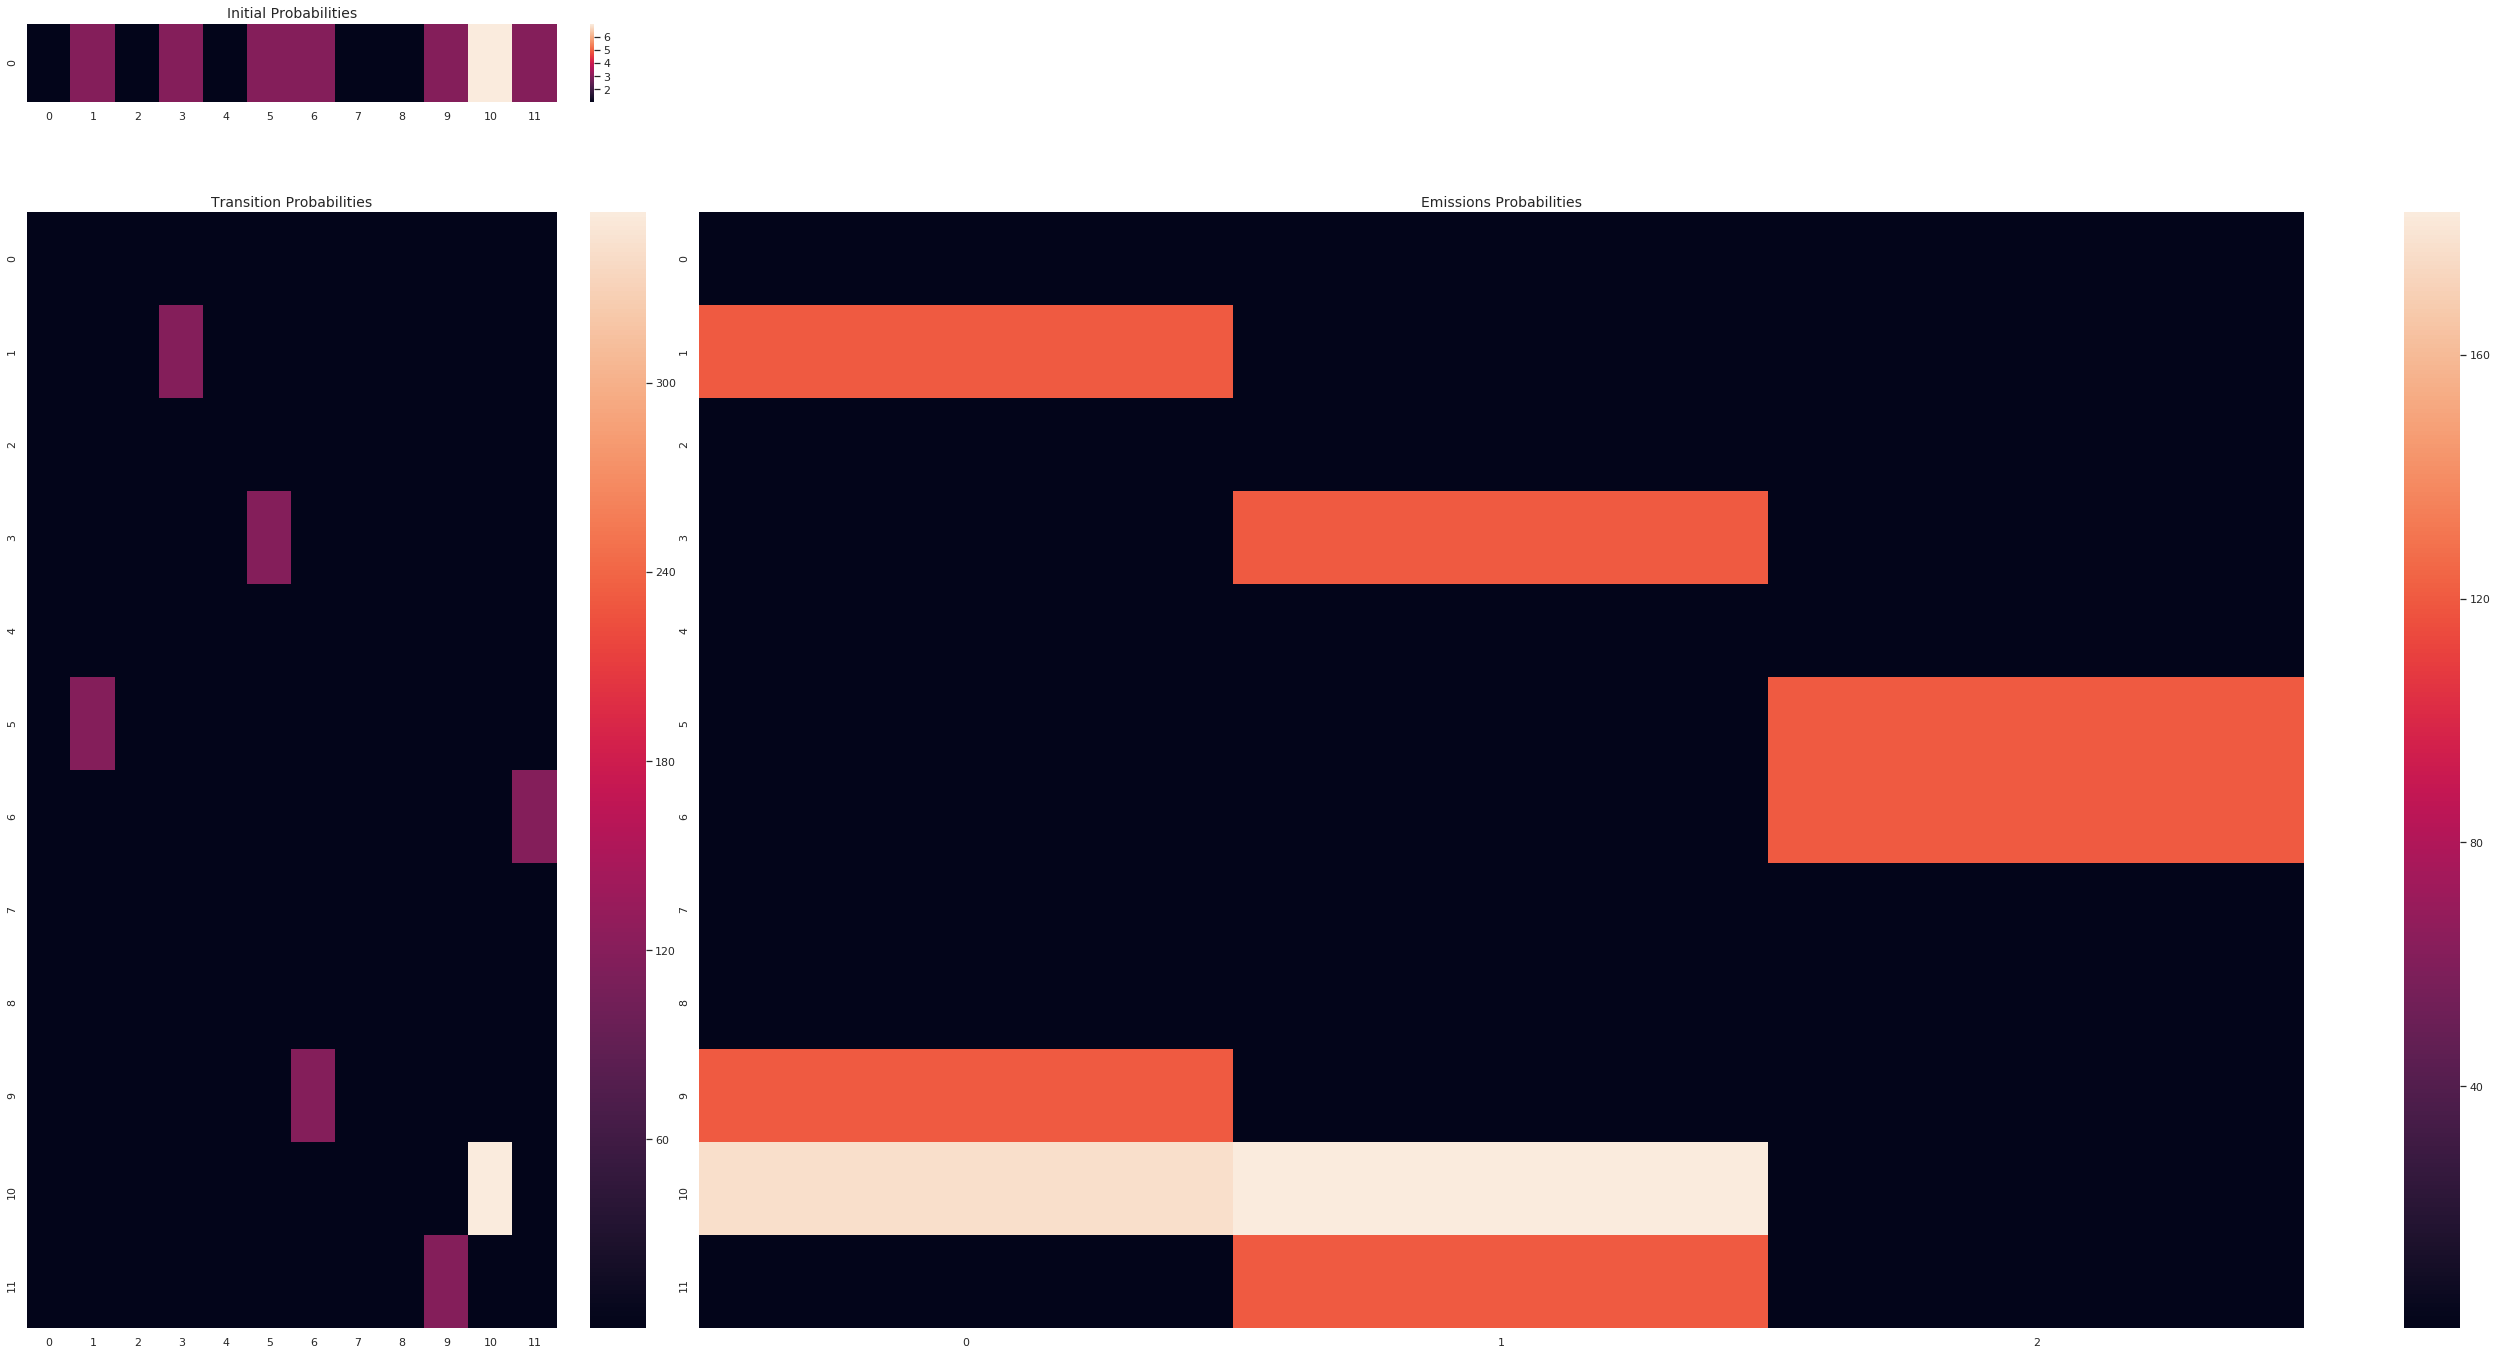

In [20]:
_ = plots.hinton_diagram(model.pi_counts_, model.A_counts_, model.B_counts_)

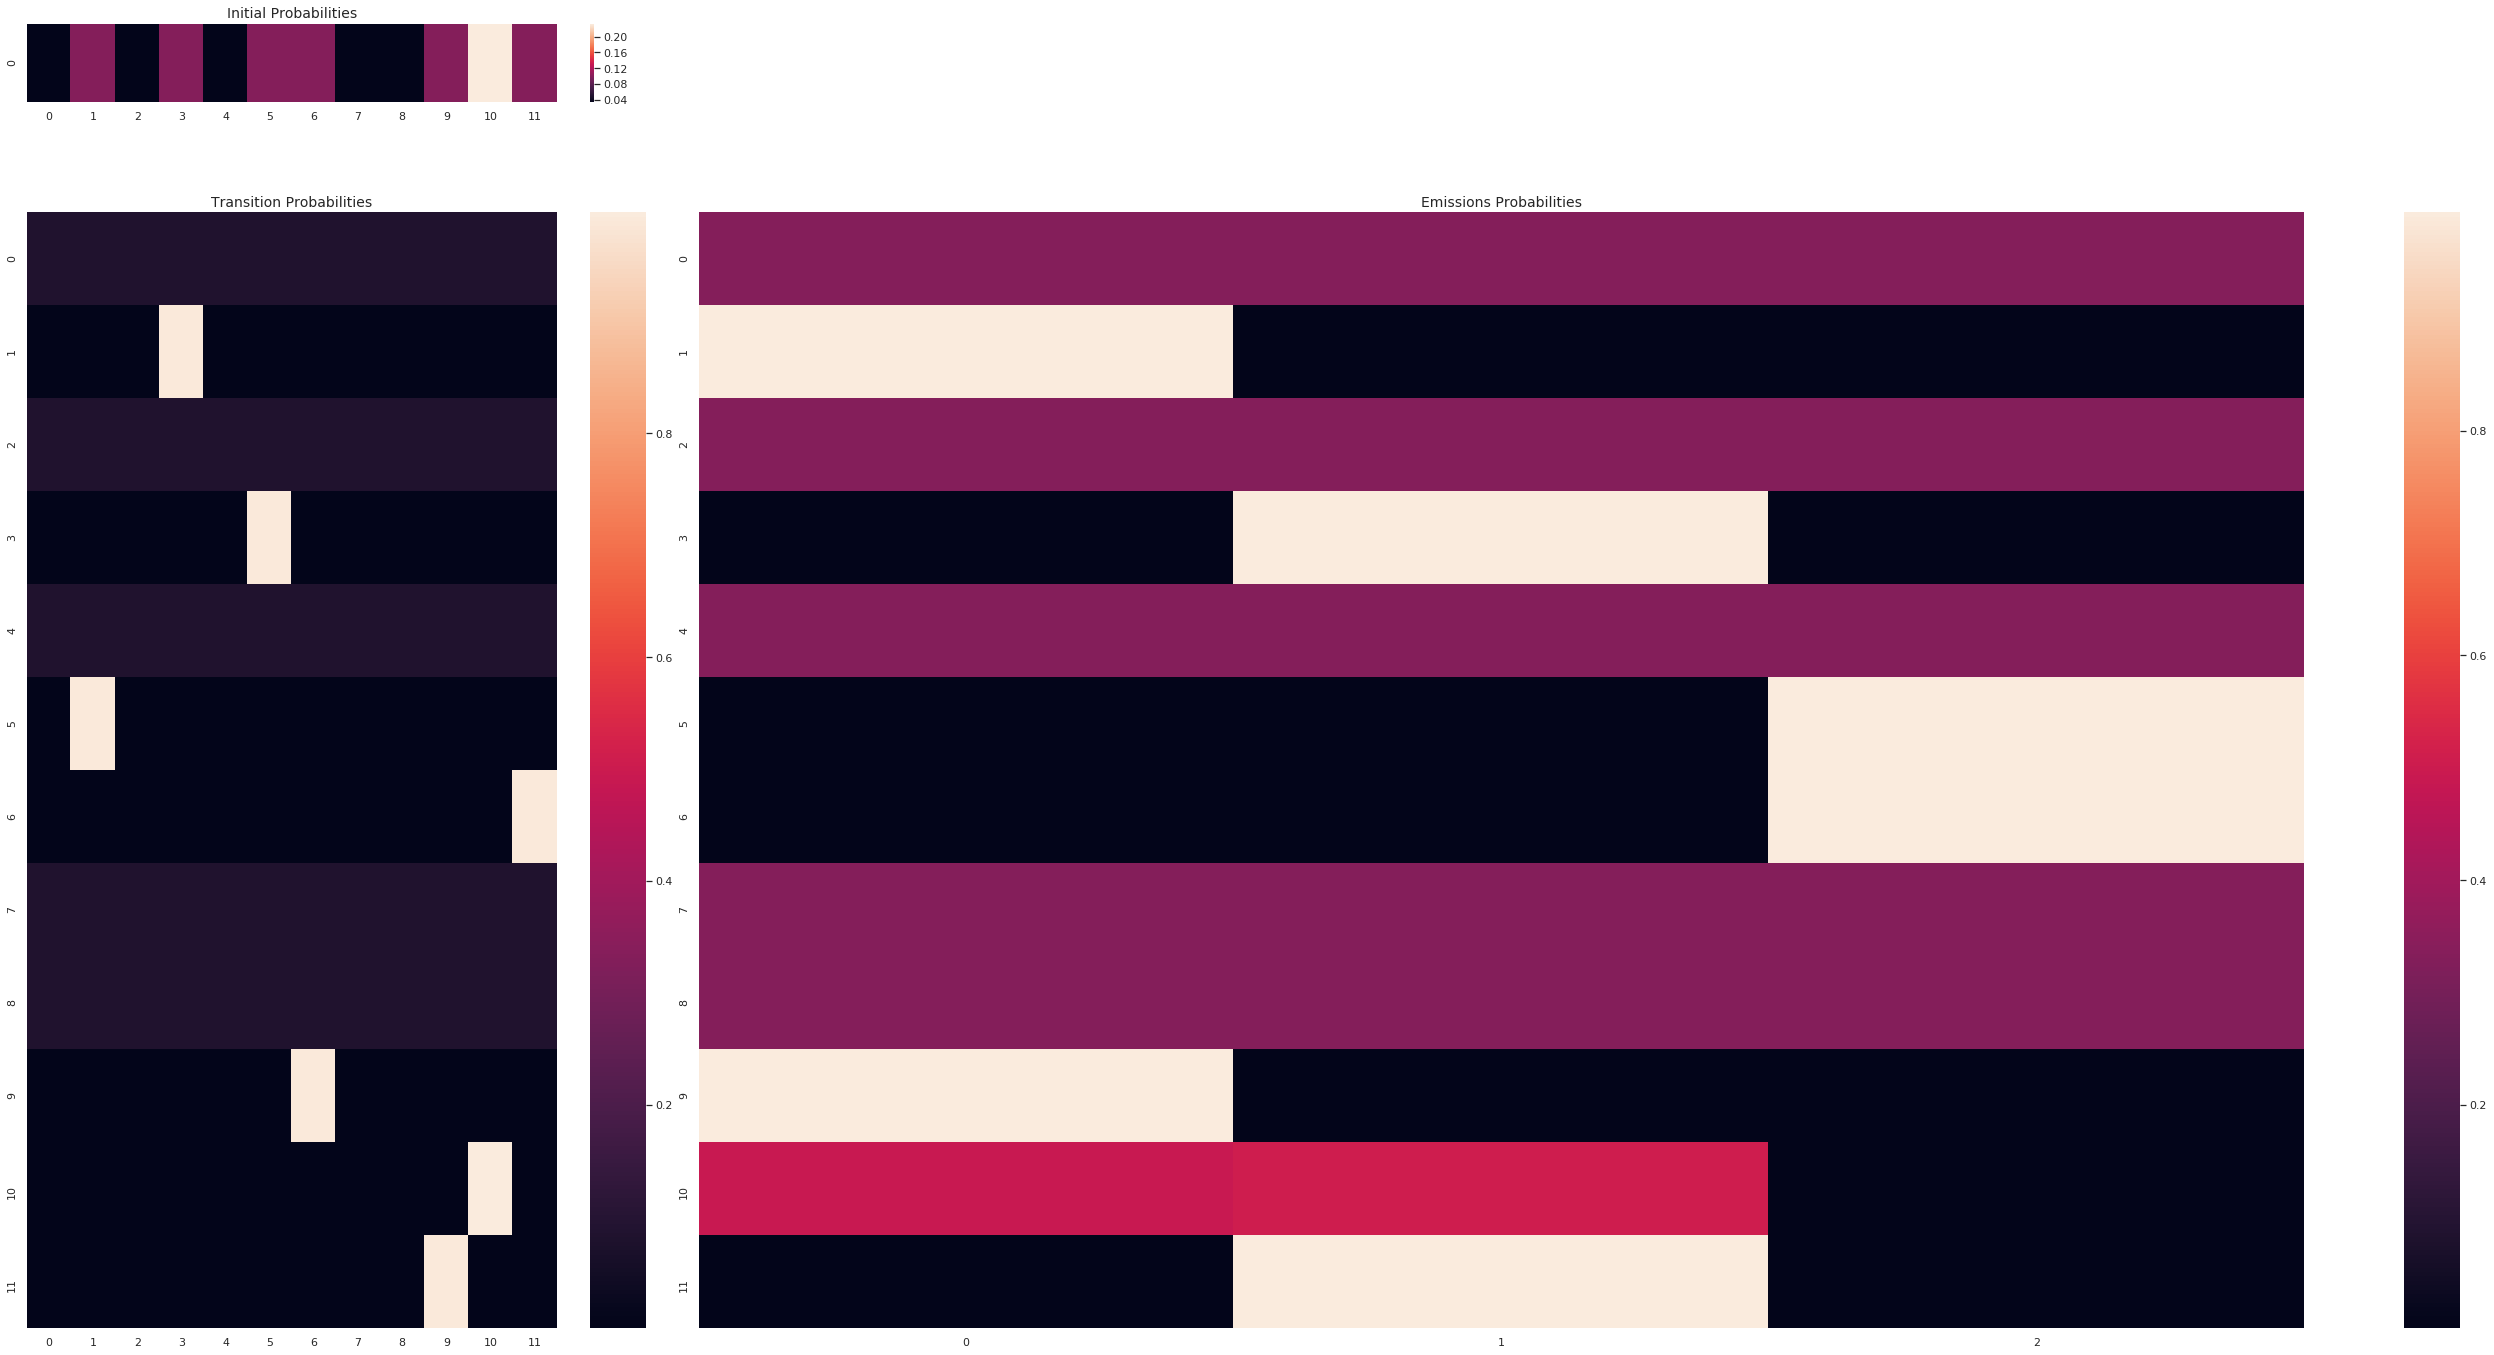

In [21]:
_ = plots.hinton_diagram(model.pi_normalized_, model.A_normalized_, model.B_normalized_)

In [22]:
vb_models = {}
for n in range(1,20):
    model = CategoricalVariationalHMM.CategoricalVariationalHMM(n_components=n, n_iterations=1000, n_inits=10)
    model.fit(data)
    vb_models[n] = model

In [23]:
def factorial(n):
    if n == 1:
        return n
    return n * factorial(n-1)

In [24]:
components = list(vb_models)
lower_bounds = [m[1].lower_bound_[-1] for m in vb_models.items()]
lower_bounds = pd.Series(lower_bounds, index=components)
adjusted_lower_bounds = pd.Series([m[1].adjusted_lower_bound_[-1] for m in vb_models.items()], index=components)

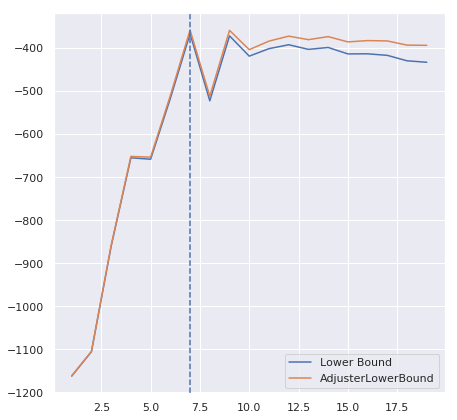

In [25]:
f, ax = plt.subplots(figsize=(7,7))
lower_bounds.plot(label="Lower Bound", ax=ax)
adjusted_lower_bounds.plot(label="AdjusterLowerBound", ax=ax)
ax.legend()
ax.axvline(adjusted_lower_bounds.idxmax(), linestyle="--")
#ax.axvline(lower_bounds.idxmax(), linestyle="-.")

### Experiment setup


In [26]:
n_iterations = 1000
n_inits = 50
random_state = sklearn.utils.check_random_state(None)

In [27]:
mixture_exploration = {}
for n_mixture_components in range(1,5):
    if n_mixture_components == 1:
        for n_components in range(3, 13):
            explored_mixture = CategoricalVariationalHMM.CategoricalVariationalHMM(
                n_components=n_components,
                n_iterations=n_iterations,
                n_inits=n_inits,
                random_state=random_state
            )
            explored_mixture.fit(data)
            mixture_exploration[(n_mixture_components, n_components)] = explored_mixture
    else:
        for n_components in range(2, 6):
            explored_mixture = CategoricalVariationalMHMM.CategoricalVariationalMHMM(
            n_mixture_components=n_mixture_components,
            n_components=n_components,
                n_iterations=n_iterations,
                n_inits=n_inits,
                random_state=random_state
            )
            explored_mixture.fit(data)
            mixture_exploration[(n_mixture_components, n_components)] = explored_mixture

In [28]:
mixture_results = []
for (n_mixture_components, n_components), model in mixture_exploration.items():
    r = {}
    r["K"] = n_mixture_components
    r["N"] = n_components
    r["LB"] = model.lower_bound_[-1]
    r["ALB"] = model.adjusted_lower_bound_[-1]
    r["BIC"] = model.bic(data)
    r["AIC"] = model.aic(data)
    r["CAIC"] = model.caic(data)
    r["LL"] = model.score(data)
    #r["iter"] = np.mean([len(l) for l in model.explored_lower_bounds_])
    mixture_results.append(r)

columns = ["LB", "ALB", "AIC", "BIC", "CAIC", "LL"]#, "iter"]

mixture_results = pd.DataFrame(mixture_results).set_index(["K", "N"])[columns]

    

In [29]:
mixture_results

LB         ALB          AIC          BIC         CAIC         LL
K N                                                                           
1 3  -860.371859 -858.580100  1674.776326  1729.608206  1740.608206 -45.910454
  4  -655.164401 -651.986347  1234.758046  1264.666344  1270.666344 -33.965501
  5  -658.454884 -653.667392  1235.122547  1265.030845  1271.030845 -33.975626
  6  -517.246762 -510.667511   917.250078   952.143093   959.143093 -25.090280
  7  -367.116244 -358.591083   599.315580   634.208595   641.208595 -16.258766
  8  -369.780604 -359.176001   599.627343   634.520357   641.520357 -16.267426
  9  -372.051195 -359.249367   599.891928   634.784942   641.784942 -16.274776
  10 -389.378178 -374.273766   622.176701   657.069715   664.069715 -16.893797
  11 -380.251548 -362.749240   602.106284   636.999298   643.999298 -16.336286
  12 -393.020321 -373.033106   616.737855   656.615585   664.615585 -16.687163
2 2  -971.484223 -970.097928  1850.380096  1880.288394  1886.288394 -51.066114
  3  -581.487972 -579.003066  1030.502213  1105.272957  1120.272957 -27.791728
  4  -369.865686 -365.994485   575.152402   610.045417   617.045417 -15.587567
  5  -375.150504 -369.669865   576.094164   610.987179   617.987179 -15.613727
3 2  -973.356222 -970.871316  1850.379139  1880.287437  1886.287437 -51.066087
  3  -374.406238 -370.822719   557.396466   592.289480   599.289480 -15.094346
  4  -371.737686 -366.767872   575.152402   610.045417   617.045417 -15.587567
  5  -377.022503 -370.443252   576.094164   610.987179   617.987179 -15.613727
4 2  -974.484413 -970.613212  1850.378181  1880.286479  1886.286479 -51.066061
  3  -376.011815 -371.042002   557.396466   592.289480   599.289480 -15.094346
  4  -372.865876 -366.509769   575.152402   610.045417   617.045417 -15.587567
  5  -378.150694 -370.185148   576.094164   610.987179   617.987179 -15.613727

In [30]:
print(mixture_results.to_latex(float_format="{:.2f}".format, bold_rows=True))

\begin{tabular}{llrrrrrr}
\toprule
  &    &      LB &     ALB &     AIC &     BIC &    CAIC &     LL \\
\textbf{K} & \textbf{N} &         &         &         &         &         &        \\
\midrule
\textbf{1} & \textbf{3 } & -860.37 & -858.58 & 1674.78 & 1729.61 & 1740.61 & -45.91 \\
  & \textbf{4 } & -655.16 & -651.99 & 1234.76 & 1264.67 & 1270.67 & -33.97 \\
  & \textbf{5 } & -658.45 & -653.67 & 1235.12 & 1265.03 & 1271.03 & -33.98 \\
  & \textbf{6 } & -517.25 & -510.67 &  917.25 &  952.14 &  959.14 & -25.09 \\
  & \textbf{7 } & -367.12 & -358.59 &  599.32 &  634.21 &  641.21 & -16.26 \\
  & \textbf{8 } & -369.78 & -359.18 &  599.63 &  634.52 &  641.52 & -16.27 \\
  & \textbf{9 } & -372.05 & -359.25 &  599.89 &  634.78 &  641.78 & -16.27 \\
  & \textbf{10} & -389.38 & -374.27 &  622.18 &  657.07 &  664.07 & -16.89 \\
  & \textbf{11} & -380.25 & -362.75 &  602.11 &  637.00 &  644.00 & -16.34 \\
  & \textbf{12} & -393.02 & -373.03 &  616.74 &  656.62 &  664.62 & -16.69 \\
\textbf{2} &

In [31]:

mixture_results[["LB", "ALB", "LL"]].idxmax()

LB     (1, 7)
ALB    (1, 7)
LL     (4, 3)
dtype: object

In [32]:

mixture_results[["AIC", "BIC", "CAIC"]].idxmin()

AIC     (4, 3)
BIC     (4, 3)
CAIC    (4, 3)
dtype: object

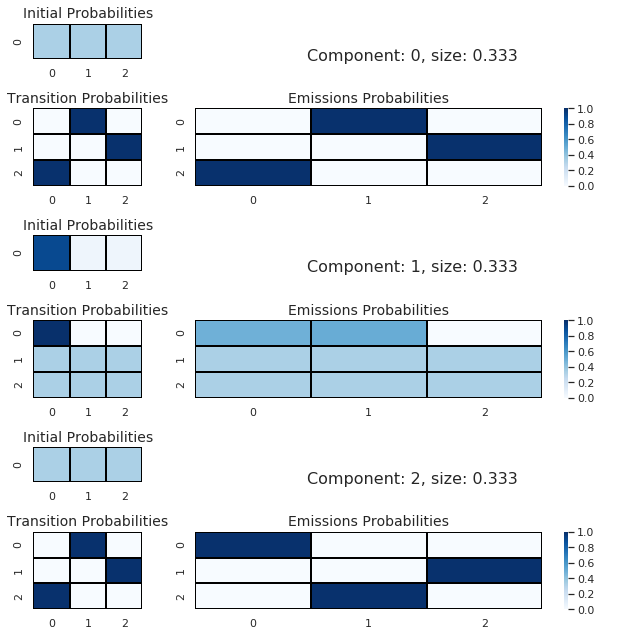

In [33]:
m = mixture_exploration[(3,3)]
fig = categorical_mixture_hinton(
    m.mixture_weights_normalized_, 
    m.pi_normalized_, 
    m.A_normalized_,
    m.B_normalized_, 
    vmin=0, 
    vmax=1,
    #hm_args={"cmap":"Greys", "linewidths":1, "linecolor":"black"}
    #hm_args={"center":0.5}
    
    #hm_args={"cmap":"Blues"}
    hm_args={"cmap":"Blues", "linewidths":1, "linecolor":"black"}
)
#fig.savefig("../../thesis/report/graphics/hinton_mixture_categorical_3_3.png")

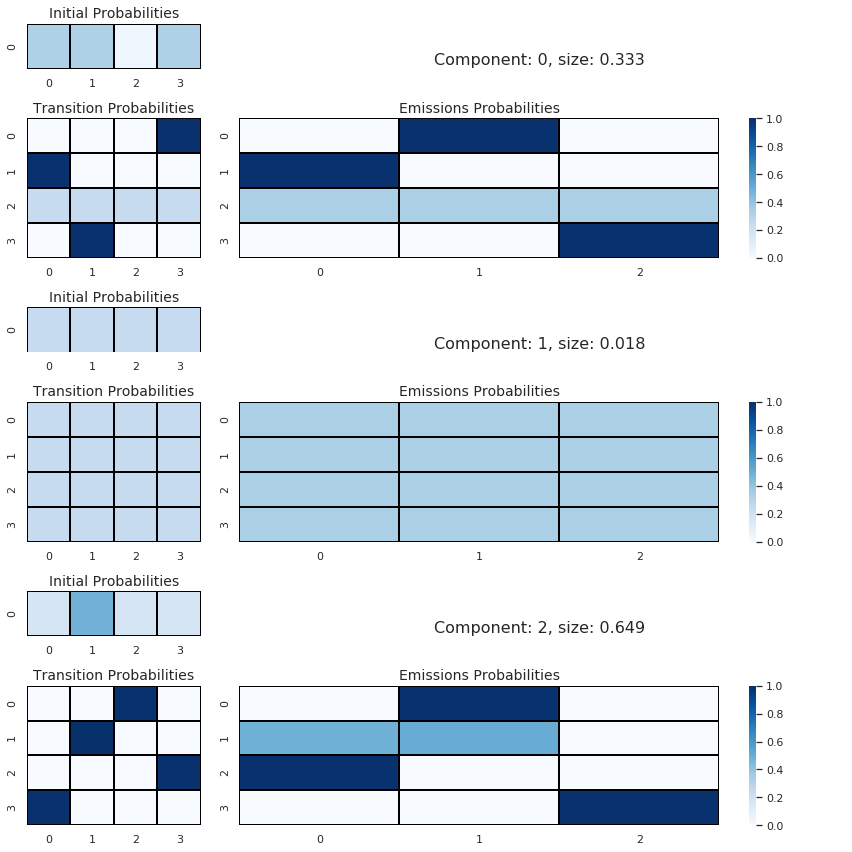

In [34]:
m = mixture_exploration[(3, 4)]
fig = categorical_mixture_hinton(
    m.mixture_weights_normalized_, 
    m.pi_normalized_, 
    m.A_normalized_,
    m.B_normalized_, 
    vmin=0, 
    vmax=1,
    #hm_args={"cmap":"Greys", "linewidths":1, "linecolor":"black"}
    #hm_args={"center":0.5}
    
    #hm_args={"cmap":"Blues"}
    hm_args={"cmap":"Blues", "linewidths":1, "linecolor":"black"}
)
# fig.savefig("../../thesis/report/graphics/hinton_mixture_categorical_3_4.png")

In [35]:
import scipy.linalg
class VariationalBlock(CategoricalVariationalHMM.CategoricalVariationalHMM):

    def _init_A(self, X):
        rs = sklearn.utils.check_random_state(self.random_state)
        blocks = []
        self.block_size = 3
        n_blocks = self.n_components // self.block_size
        for i in range(n_blocks):
            blocks.append(
                sklearn.preprocessing.normalize(
                    rs.rand(self.block_size, self.block_size),
                    norm="l1",
                    axis=1)
            )
    
        self.A_prior_ = scipy.linalg.block_diag(*blocks)
        self.A_prior_[self.A_prior_==0] = 1/1000
        #print(self.A_prior_)
        self.A_counts_ = self.A_prior_ * X.shape[0] * X.shape[1] / 4
    pass


In [36]:
block = VariationalBlock( n_components=9, n_inits=n_inits, n_iterations=n_iterations, n_jobs=1, tol=1e-12)
block.block_size =3
block12 = VariationalBlock( n_components=12, n_inits=n_inits, n_iterations=n_iterations, n_jobs=1, tol=1e-12)
block12.block_size =3

In [37]:
%time block.fit(data)


CPU times: user 20.8 s, sys: 7.49 ms, total: 20.8 s
Wall time: 20.8 s


VariationalBlock(A_prior=None, B_prior=None, implementation='scaling',
         n_components=9, n_features=None, n_inits=50, n_iterations=1000,
         n_jobs=1, pi_prior=None, random_state=None, tol=1e-12, verbose=0)

In [38]:
%time block12.fit(data)

../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)


CPU times: user 24.2 s, sys: 7.84 ms, total: 24.2 s
Wall time: 24.2 s


VariationalBlock(A_prior=None, B_prior=None, implementation='scaling',
         n_components=12, n_features=None, n_inits=50, n_iterations=1000,
         n_jobs=1, pi_prior=None, random_state=None, tol=1e-12, verbose=0)

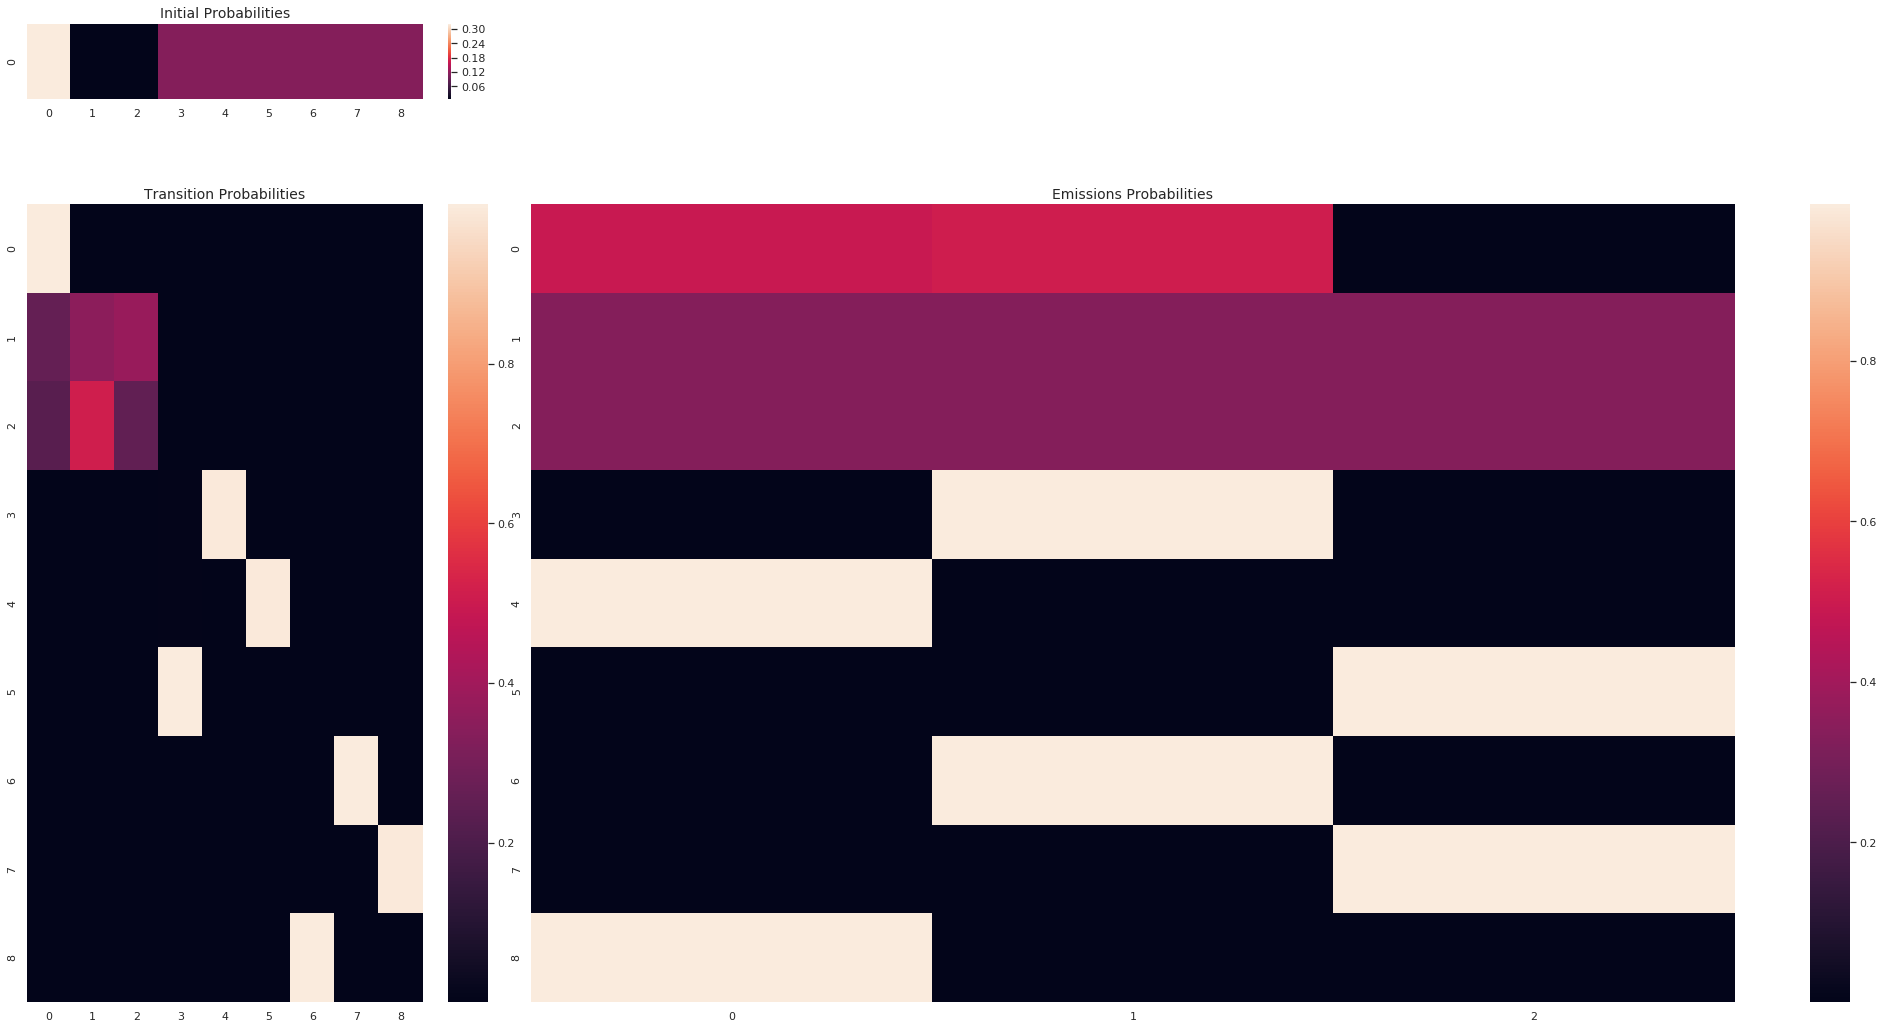

In [39]:
_ = plots.hinton_diagram(
    block.pi_normalized_,
    block.A_normalized_,
    block.B_normalized_)

In [40]:
_ = plots.hinton_diagram(
    block12.pi_normalized_,
    block12.A_normalized_,
    block12.B_normalized_)

In [41]:
block.num_free_params(), len(block.lower_bound_)

(7, 82)

In [42]:
block12.num_free_params(), len(block12.lower_bound_)

(7, 92)

In [43]:
for k, m in mixture_exploration.items():
    print(k, m.num_free_params(), len(m.lower_bound_))

(1, 3) 11 31
(1, 4) 6 17
(1, 5) 6 18
(1, 6) 7 24
(1, 7) 7 14
(1, 8) 7 22
(1, 9) 7 38
(1, 10) 7 17
(1, 11) 7 14
(1, 12) 8 38
(2, 2) 6 100
(2, 3) 15 77
(2, 4) 7 11
(2, 5) 7 145
(3, 2) 6 19
(3, 3) 7 12
(3, 4) 7 23
(3, 5) 7 76
(4, 2) 6 38
(4, 3) 7 13
(4, 4) 7 13
(4, 5) 7 16


In [44]:
len(block.lower_bound_)

82

In [45]:
block.lower_bound_[-1]

-350.63815083628776

In [46]:
block.verbose_lower_bound_[-1]

{'iteration': 81,
 'total': -350.63815083628776,
 'pi': -9.850195152993642,
 'A': -20.500516696049424,
 'B': -25.967243912447636,
 'subnormed_log_prob': -294.3201950747971}

In [47]:
block12.verbose_lower_bound_[-1]

{'iteration': 91,
 'total': -352.1398608413094,
 'pi': -11.843318256382808,
 'A': -19.726708635732567,
 'B': -25.96724650558091,
 'subnormed_log_prob': -294.6025874436132}

In [48]:
mixture_exploration[(3,3)].verbose_lower_bound_[-1]

{'iteration': 11,
 'total': -374.40623763010325,
 'component_states': -20.755539611548695,
 'component_weights': -2.497943743898624,
 'pi': -4.515836040691218,
 'A': -25.237492421103667,
 'B': -25.967244956733303,
 'subnormed_log_prob': -295.43218085612773}

In [49]:
block.score(data)

-16.13622400960925

In [63]:
block.pi_prior_

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [62]:
block.pi_counts_

array([6.11111039, 0.11111156, 0.11111138, 2.11111242, 2.11111176,
       2.11110915, 2.11111039, 2.11111142, 2.11111152])

In [61]:
block.pi_counts_.reshape(3,3).sum(axis=1)

array([6.33333333, 6.33333333, 6.33333333])

In [50]:
mixture_exploration[(3,3)].score(data)

-15.094346270533533

In [51]:
m = mixture_exploration[(3,3)]

In [52]:
m.pi_posterior_

array([[2.33333333, 2.33333333, 2.33333333],
       [6.33219689, 0.33390155, 0.33390155],
       [2.33333333, 2.33333333, 2.33333333]])

In [64]:
m.mixture_weights_prior_

array([0.33333333, 0.33333333, 0.33333333])

In [53]:
m.mixture_weights_posterior_

array([6.33333333, 6.33333333, 6.33333333])

In [59]:
m.pi_posterior_.sum(axis=1)

array([7., 7., 7.])

In [54]:
m.pi_subnormalized_

array([[0.2851277 , 0.2851277 , 0.2851277 ],
       [0.89747338, 0.00674408, 0.00674408],
       [0.2851277 , 0.2851277 , 0.2851277 ]])

In [57]:
m.mixture_weights_subnormalized_

array([0.31566128, 0.31566128, 0.31566128])

In [56]:
assert False

AssertionError: 

In [ ]:
model.lower_bound_

In [ ]:
for k, v in mixture_exploration.items():
    print(k, v.lower_bound_[-1])

In [ ]:
for k, v in mixture_exploration.items():
    _ = plots.categorical_mixture_hinton(
    v.mixture_weights_normalized_, 
    v.pi_normalized_, 
    v.A_normalized_,
    v.B_normalized_, 
    vmin=0, 
    vmax=1
)

In [ ]:
assert False

In [ ]:
em_hmm = CategoricalHMM.CategoricalHMM(n_components=12, n_iterations=5000, n_inits=5)
em_hmm.fit(data)

In [ ]:
plots.multiple_learning_plot(em_hmm.explored_loglikelihoods_)

In [ ]:
plots.learning_plot(em_hmm.loglikelihoods_)

In [ ]:
_ = plots.hinton_diagram(em_hmm.pi_, em_hmm.A_, em_hmm.B_)

In [ ]:
em_hmm.score(data)

In [ ]:
em_hmm.transform(data)

In [ ]:
em_hmm.predict_log_proba(data)

In [ ]:
em_hmm.bic(data)

In [ ]:
searcher = HMMSearch.HMMSearch(estimator=CategoricalHMM.CategoricalHMM(n_iterations=1000), n_inits=20, n_components=list(range(2,20)))

In [ ]:
searcher.fit(data)

In [ ]:
_ = plots.plot_bic_aic(searcher.scores_)

In [ ]:
searcher.best_model_.score_samples(data)

In [ ]:
_ = plots.hinton_diagram(searcher.best_model_.pi_,searcher.best_model_.A_, searcher.best_model_.B_)

In [ ]:
_ = plots.hinton_diagram(searcher.bests_[7].pi_,searcher.bests_[7].A_, searcher.bests_[7].B_)

In [ ]:
vi_models = {}
for i in range(2, 20):
    vi_models[i] = CategoricalVariationalHMM.CategoricalVariationalHMM(n_components=i,n_iterations=500, n_inits=20, pi_prior=1)
    vi_models[i].fit(data)

In [ ]:
scores = []
for i, m in vi_models.items():
    scores.append(m.dic(data))

In [ ]:
idx = list(vi_models.keys())

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
ax.bar(idx, scores)
_ = ax.set_xticks(idx)

In [ ]:
scores

In [ ]:
def do_hinton(m):
    plots.hinton_diagram(
    m.pi_normalized_,
    m.A_normalized_,
    m.B_normalized_)

do_hinton(vi_models[7])

In [ ]:
do_hinton(vi_models[8])